In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import pickle
import warnings

warnings.filterwarnings("ignore")

In [57]:
def _extrapolate_trend(trend, npoints):
    """
    Replace nan values on trend's end-points with least-squares extrapolated
    values with regression considering npoints closest defined points.
    """
    front = next(i for i, vals in enumerate(trend) if not np.any(np.isnan(vals)))
    back = trend.shape[0] - 1 - next(i for i, vals in enumerate(trend[::-1]) if not np.any(np.isnan(vals)))
    front_last = min(front + npoints, back)
    back_first = max(front, back - npoints)

    k, n = np.linalg.lstsq(np.c_[np.arange(front, front_last), np.ones(front_last - front)], trend[front:front_last], rcond=-1)[0]
    extra = (np.arange(0, front) * np.c_[k] + np.c_[n]).T
    if trend.ndim == 1:
        extra = extra.squeeze()
    trend[:front] = extra

    k, n = np.linalg.lstsq(
        np.c_[np.arange(back_first, back), np.ones(back - back_first)], trend[back_first:back], rcond=-1)[0]
    extra = (np.arange(back + 1, trend.shape[0]) * np.c_[k] + np.c_[n]).T
    if trend.ndim == 1:
        extra = extra.squeeze()
    trend[back + 1:] = extra

    return trend

# Example time series

### NASDAQ

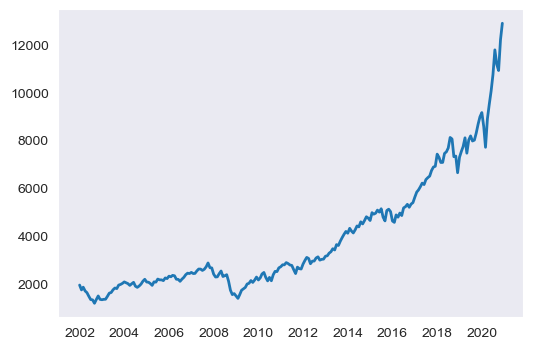

In [58]:
df = pd.read_csv('data/NASDAQ.csv')
df = df.set_index(pd.to_datetime(df['Date'])).drop(columns=['Date','Volume','Open','High','Low','Adj Close']).rename(columns={'Close':'value'})
df = df['2002':'2020']
plt.figure(figsize=(6,4))
plt.plot(df.index,df['value'],linewidth=2)
# plt.ylabel('NASDAQ',fontsize=12)
plt.grid()

### unemployment

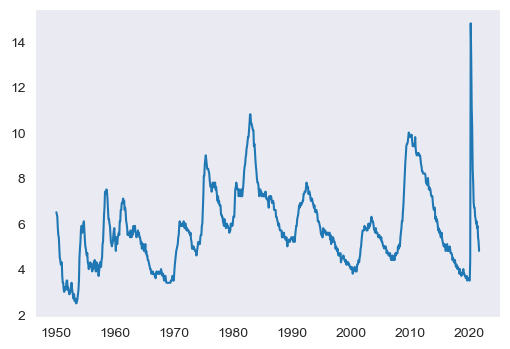

In [59]:
df = pd.read_csv('data/UNRATE.csv')
df = df.set_index(pd.to_datetime(df['DATE'])).drop(columns='DATE')
df = df['1950':]

plt.figure(figsize=(6,4))
plt.plot(df.index,df['UNRATE'])
plt.grid()
# plt.ylabel('US unemployment [%]',fontsize=12)

### sunspots

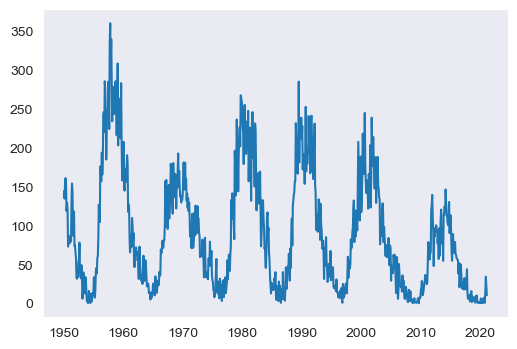

In [60]:
df = pd.read_csv('data/Sunspots.csv')
df = df.set_index(pd.to_datetime(df['Date'])).drop(columns=['Unnamed: 0','Date']).rename(columns={'Monthly Mean Total Sunspot Number':'values'})

df = df['1950':]

plt.figure(figsize=(6,4))
plt.plot(df.index,df['values'])
plt.grid()

### stationary process

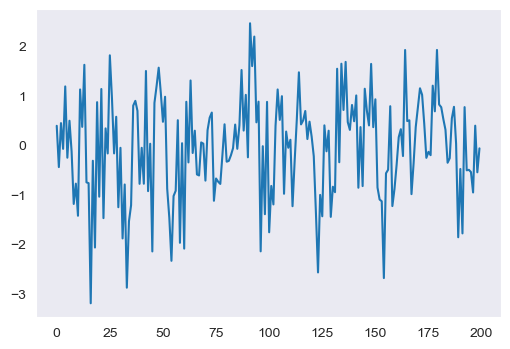

In [61]:
ar = [0.4, 0.2]
ma = [0.3, 0.3, 0.3]
process = sm.tsa.ArmaProcess(ar,ma)

z = process.generate_sample(nsample=200)

plt.figure(figsize=(6,4))
plt.plot(z)
plt.grid()

# Load sunspots data

In [62]:
df_min = pd.read_csv('data/mining.csv')
df_mining = df_min.copy()
df_mining.reset_index(inplace=True)
df_mining.drop(columns=['footnote_codes','series_id'], axis=0, inplace=True)
def colums_add_value(raw):
    return f"01-{raw['period'][-2:]}-{str(raw['year'])}"
df_mining['years'] = df_mining.apply(colums_add_value, axis=1)
df_mining.dropna(inplace=True)
df_mining.drop(['year','period', 'index'], axis=1, inplace=True)
df_mining = df_mining.query("years.str.startswith('01-01')")
df_mining = df_mining.groupby(['years']).agg('mean')
df_mining.index = pd.to_datetime(df_mining.index)
df_mining.sort_index(inplace=True)
#df_mining = df_mining['value']
df = df_mining

Text(0, 0.5, 'Number of sunspots')

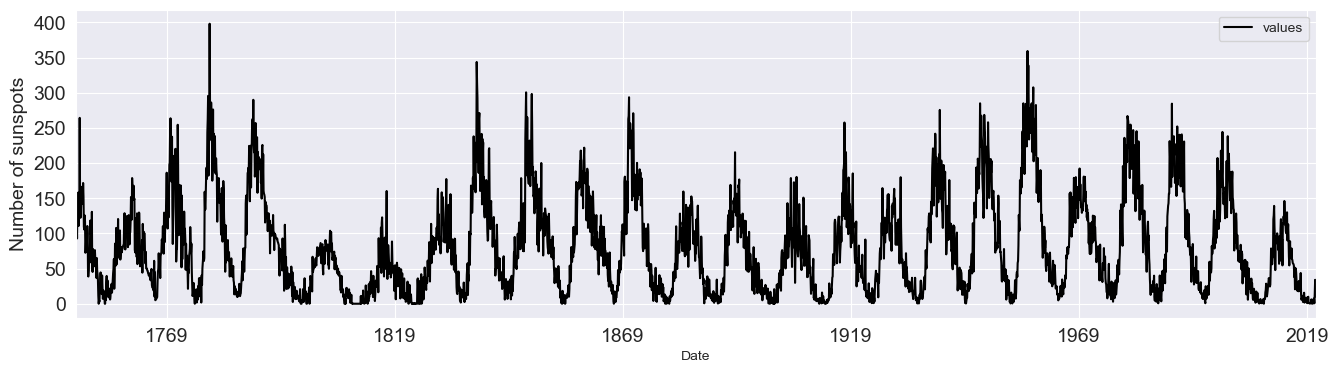

In [63]:
df = pd.read_csv('data/Sunspots.csv')
df = df.set_index(pd.to_datetime(df['Date'])).drop(columns=['Unnamed: 0','Date']).rename(columns={'Monthly Mean Total Sunspot Number':'values'})

df.plot(figsize=(16,4),color='k',grid=True)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)

### Keep only recent data

In [64]:
y_hist = df['1900':'1984']['values']
y_future = df['1985':'2000']['values']

h = len(y_hist)
f = len(y_future)

Text(0, 0.5, 'Number of sunspots')

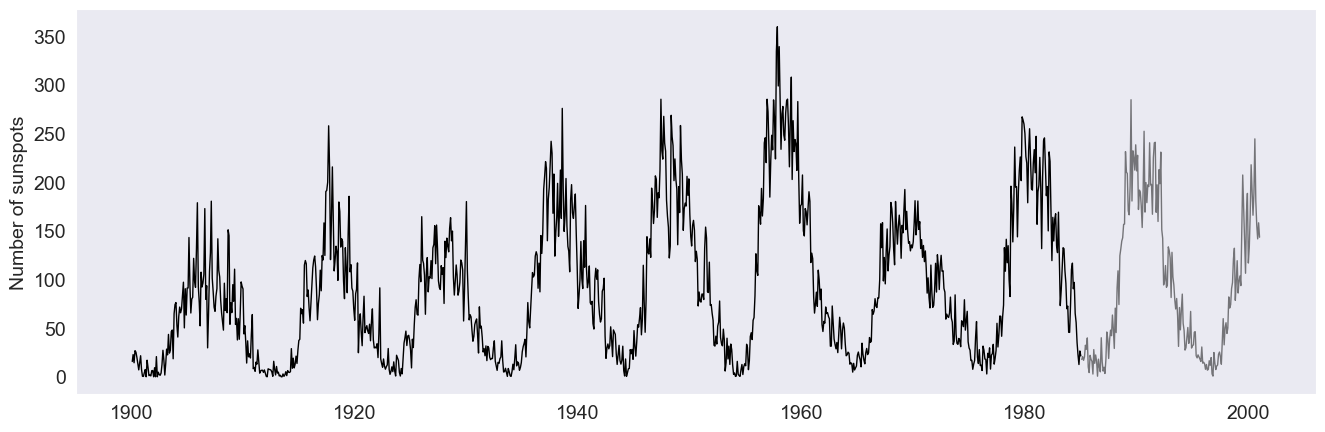

In [65]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',linewidth=1)
plt.plot(y_future,'k',linewidth=1,alpha=0.5)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)

# Trend

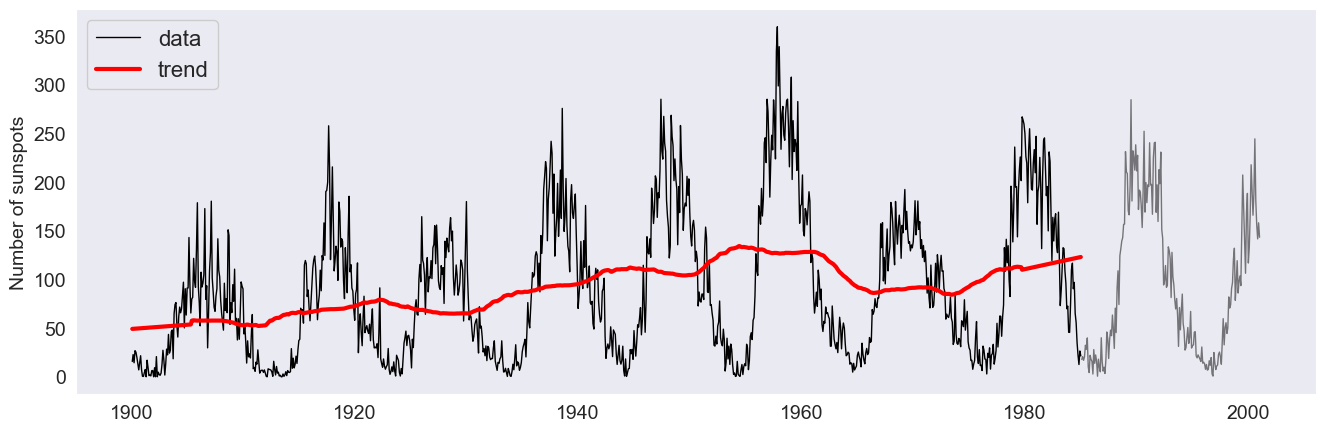

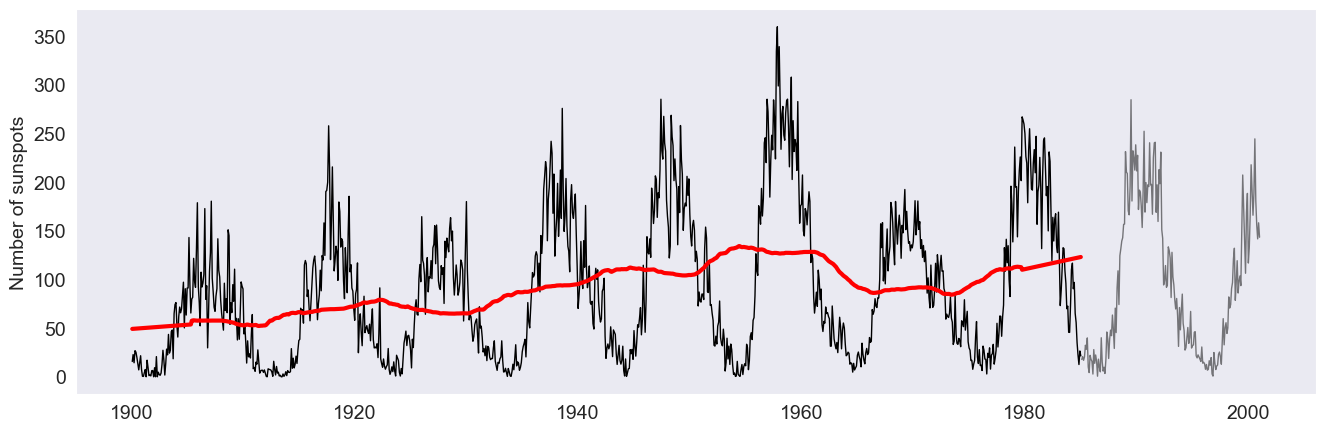

In [66]:
period = 128
filt = np.array([.5] + [1] * (period - 1) + [.5]) / period

nsides = 2
trend = convolution_filter(y_hist, filt, nsides)
trend = _extrapolate_trend(trend, period + 1)

period = None  # ensure we do not use this period

plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.legend(loc='upper left',fontsize=16,framealpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

## Find the period of the data

Text(0, 0.5, 'Number of sunspots')

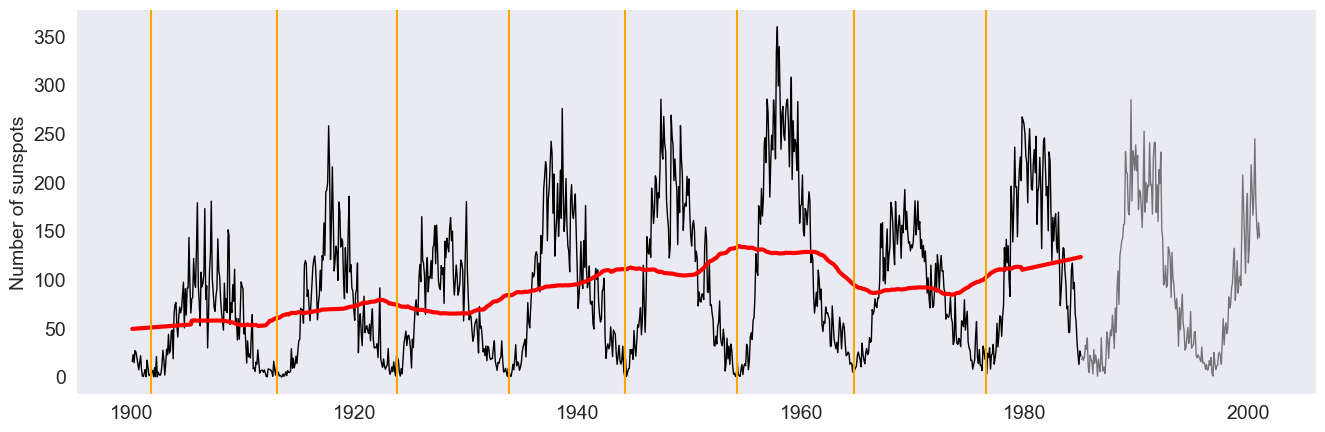

In [67]:
lows_index = [20,155,284,405,529,650,775,917]
lows = y_hist.index[lows_index]

plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
for low in lows:
    plt.axvline(x=pd.to_datetime(low),color='orange')
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)

In [68]:
detrended = y_hist - trend
detrended = detrended.to_numpy()
period = int(np.round(np.mean(np.diff(lows_index))))
num_hist_periods = len(lows)-1

period, num_hist_periods

(128, 7)

# divide into seasons

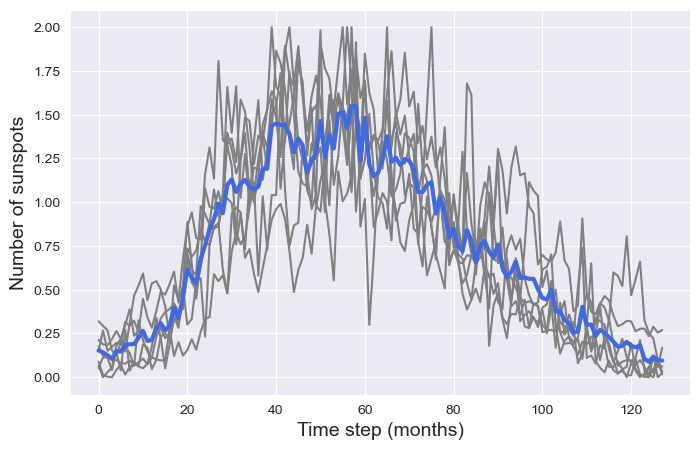

In [69]:
seasonals = np.empty((period,num_hist_periods))
for p in range(num_hist_periods):
    s = detrended[lows_index[p]:lows_index[p]+period]
    s = 2*(s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
    
mean_seasonals = seasonals.mean(axis=1)
    
plt.figure(figsize=(8,5))
for p in range(num_hist_periods):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3,label='mean seasonal')
plt.xlabel('Time step (months)',fontsize=14)
plt.xlabel('Time step (months)',fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

# smooth the seasonals

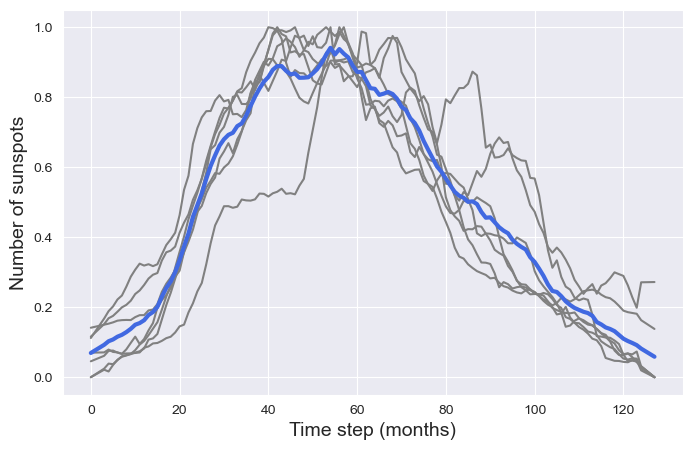

In [70]:
nsides = 2
filt_size = 9
filt = np.repeat(1.0 / filt_size, filt_size)

seasonals = np.empty((period,num_hist_periods))
for p in range(num_hist_periods):
    s = detrended[lows_index[p]:lows_index[p]+period]
    s = convolution_filter(s, filt, nsides)
    s = _extrapolate_trend(s, filt_size)
    s = (s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
    
mean_seasonals = seasonals.mean(axis=1)

plt.figure(figsize=(8,5))
for p in range(num_hist_periods):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3,label='mean seasonal')
plt.xlabel('Time step (months)',fontsize=14)
plt.xlabel('Time step (months)',fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

## remove outliers

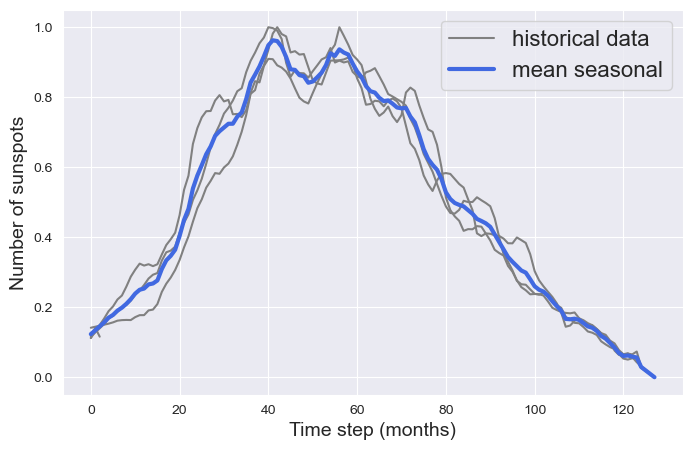

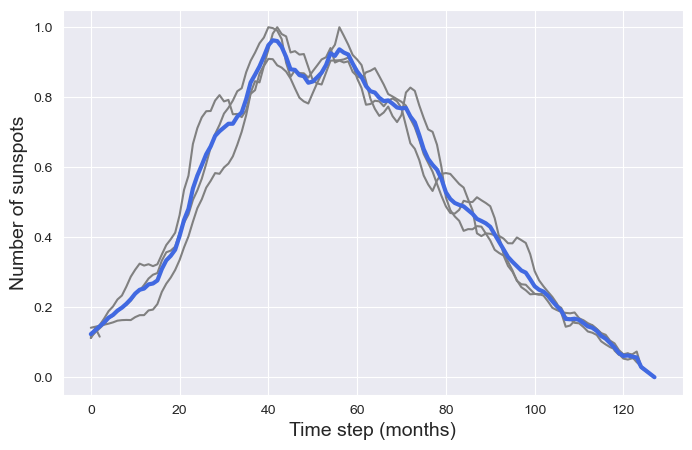

In [71]:
# plt.figure()
# for p in range(num_hist_periods):
#     plt.plot(seasonals[:,p],label=p)
# plt.legend()
# plt.xlabel('Time step (months)',fontsize=14)
# plt.xlabel('Time step (months)',fontsize=14)
# plt.ylabel('Number of sunspots',fontsize=14)
# plt.show()

# remove outliers
seasonals = seasonals[:,[2,3,4]]
mean_seasonals = seasonals.mean(axis=1)

plt.figure(figsize=(8,5))
plt.plot(seasonals[0],color=0.5*np.ones(3),label='historical data')
plt.plot(seasonals,color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3,label='mean seasonal')
plt.xlabel('Time step (months)',fontsize=14)
plt.xlabel('Time step (months)',fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(seasonals[0],color=0.5*np.ones(3),label='historical data')
plt.plot(seasonals,color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3,label='mean seasonal')
plt.xlabel('Time step (months)',fontsize=14)
plt.xlabel('Time step (months)',fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

### construct seasonal

Text(0, 0.5, 'Number of sunspots')

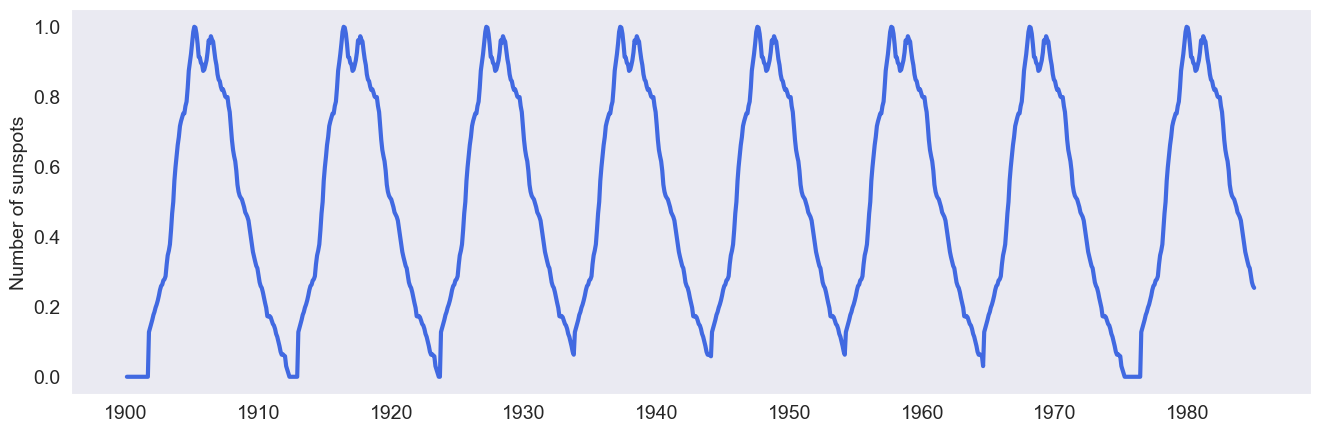

In [72]:
seasonal = pd.Series(index=y_hist.index,data=0)

for low in lows_index:
    if low+period<len(seasonal):
        seasonal[low:low+period] = mean_seasonals
    else:
        seasonal[low:] = mean_seasonals[:len(seasonal)-(low+period)]
        
        
seasonal = seasonal / np.max(seasonal)
    
plt.figure(figsize=(16,5))
plt.plot(seasonal,label='trend+seasonal',color='royalblue',linewidth=3)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)

In [73]:
season_and_trend = 2*trend*seasonal

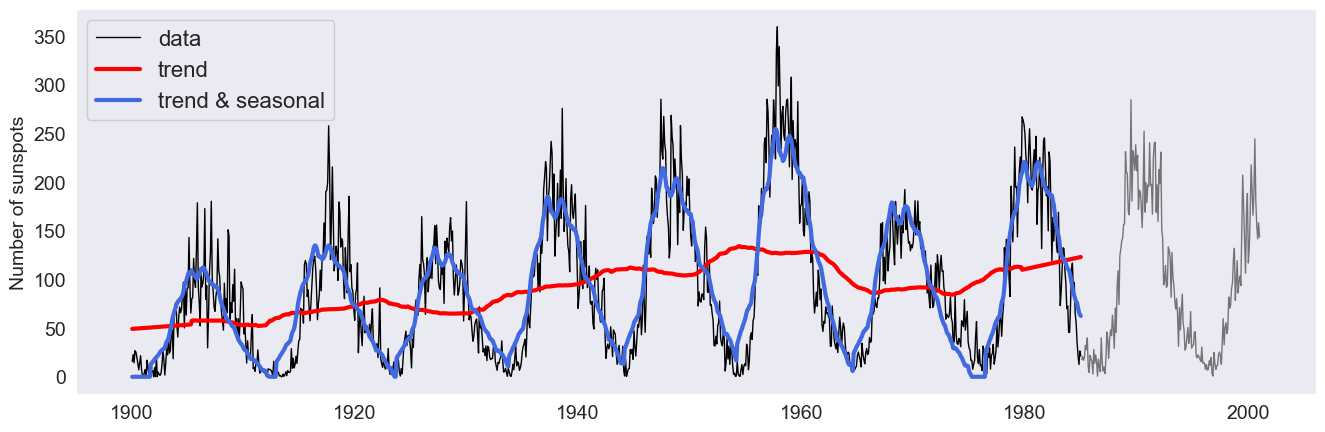

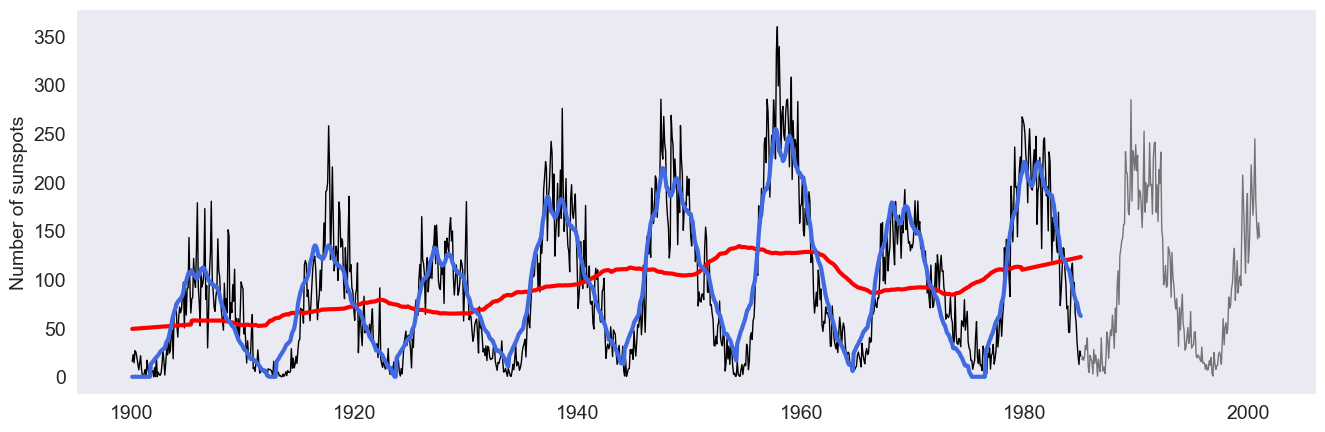

In [74]:
plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='trend & seasonal',color='royalblue',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.legend(loc='upper left',fontsize=16,framealpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='trend & seasonal',color='royalblue',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

# model residue
This is done by checking the autocorrelation coefficients
If the residue is not stationary, this might suggest that some long-term trend, or seasonality, may have remained unmodeled. 
However, if the residue is stationary, then there is not much more structure that can be extracted using decomposition techniques.

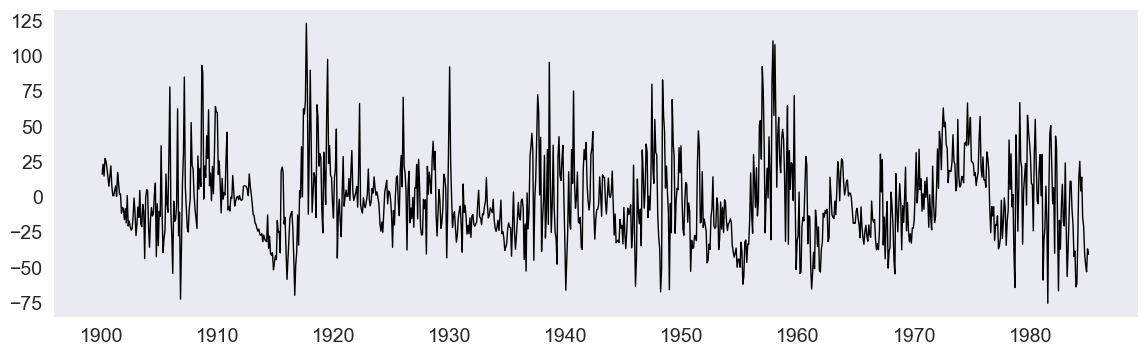

In [75]:
# res = y - y_hat
residue = y_hist - season_and_trend
plt.figure(figsize=(14,4))
plt.plot(residue,'k',linewidth=1,label='model residue')
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

### Forecast trend

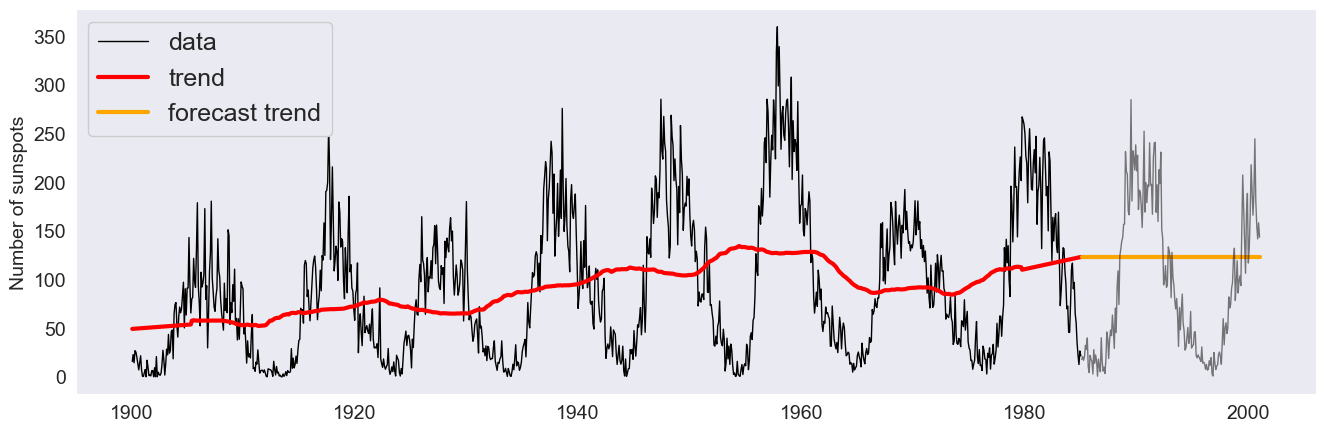

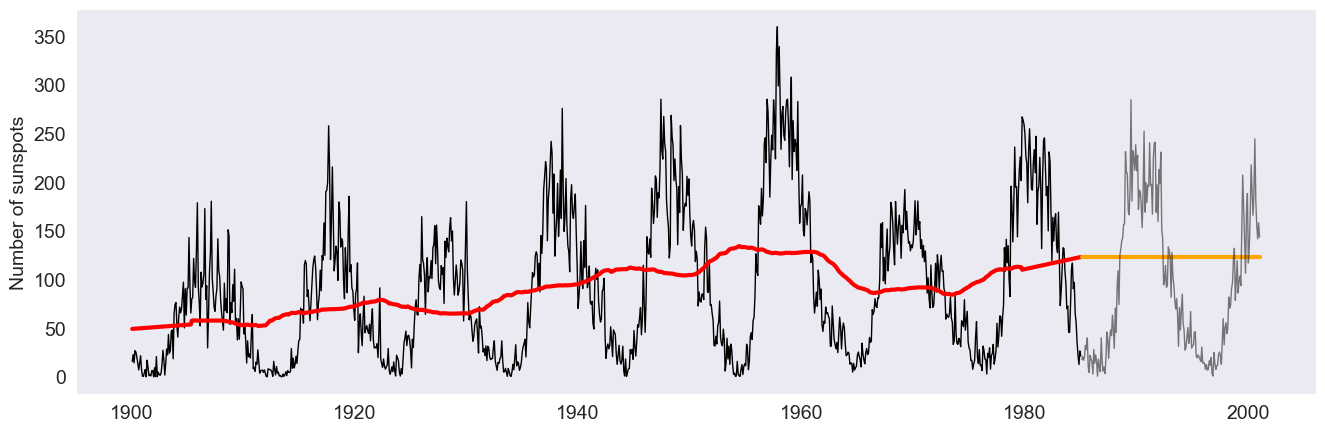

In [76]:
f_periods = int(1 + f/period)
yhat_trend = pd.Series(index=y_future.index, data=trend[-1])

plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(yhat_trend,label='forecast trend',color='orange',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.legend(loc='upper left',fontsize=18,framealpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(yhat_trend,label='forecast trend',color='orange',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

### forecast

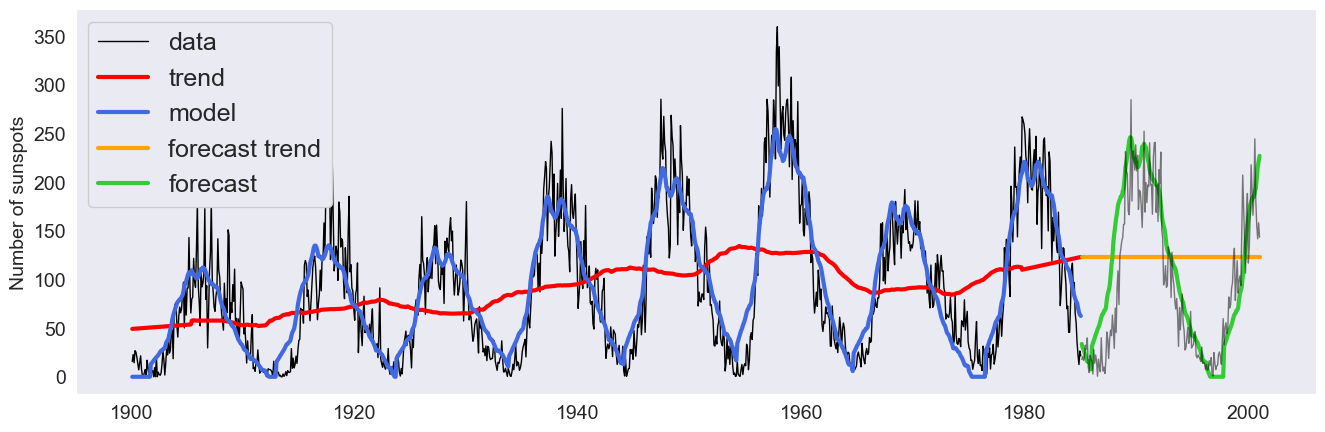

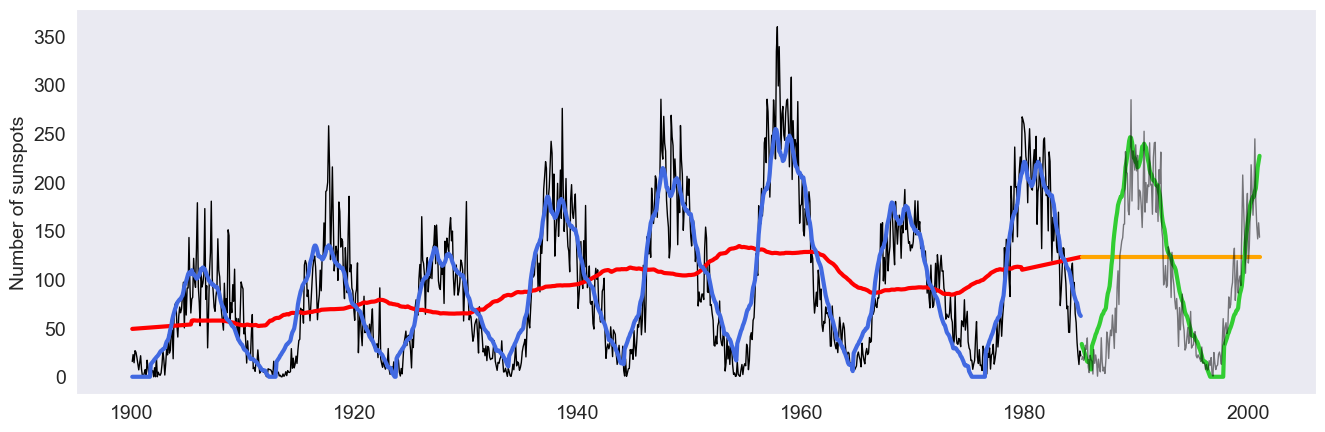

In [77]:
yhat_seasonal = pd.Series(index=y_future.index)
for i in range(len(yhat_seasonal)):
    yhat_seasonal[i] = seasonal[-(f_periods*len(mean_seasonals)-i)]
yhat = 2*yhat_trend*yhat_seasonal

plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='model',color='royalblue',linewidth=3)
plt.plot(yhat_trend,label='forecast trend',color='orange',linewidth=3)
plt.plot(yhat,label='forecast',color='limegreen',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.legend(loc='upper left',fontsize=18,framealpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

plt.figure(figsize=(16,5))
plt.plot(y_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='model',color='royalblue',linewidth=3)
plt.plot(yhat_trend,label='forecast trend',color='orange',linewidth=3)
plt.plot(yhat,label='forecast',color='limegreen',linewidth=3)
plt.plot(y_future,'k',alpha=0.5,linewidth=1)
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

### remainder, residue, error
you can compute the prediction error (as the observed data minus the forecast). 
Here is the prediction error, plotted in purple.

In [78]:
pred_error = y_future - yhat

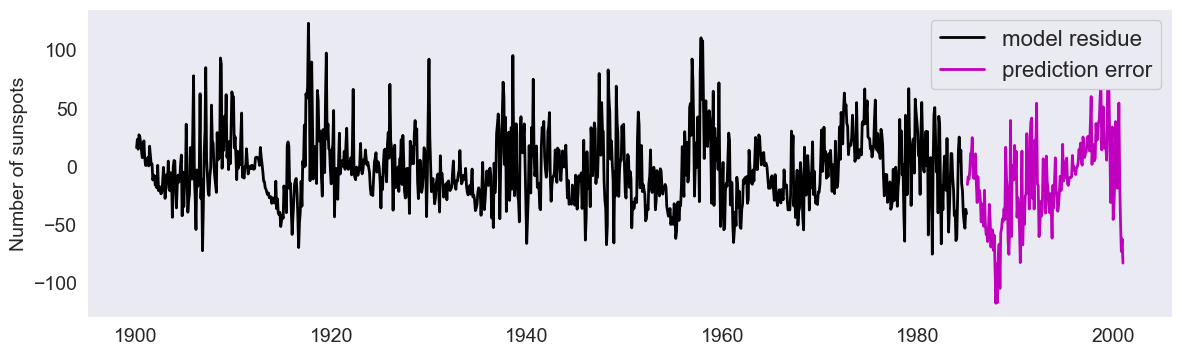

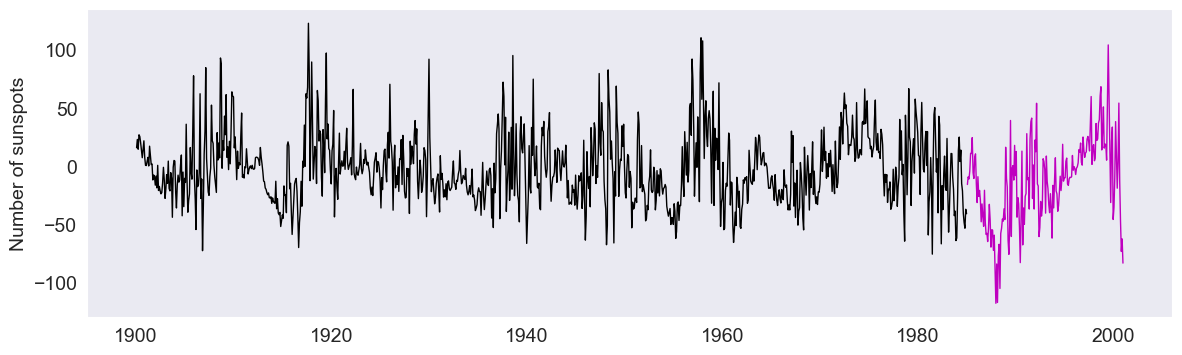

In [79]:
plt.figure(figsize=(14,4))
plt.plot(residue,'k',linewidth=2,label='model residue')
plt.plot(pred_error,'m',linewidth=2,label='prediction error')
plt.grid()
plt.legend(fontsize=16,framealpha=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

plt.figure(figsize=(14,4))
plt.plot(residue,'k',linewidth=1,label='model residue')
plt.plot(pred_error,'m',linewidth=1,label='prediction error')
plt.grid()
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Number of sunspots',fontsize=14)
plt.show()

The mean absolute error (MAE) and the root mean squared error (RMSE) applied to both the residue and the prediction error.
it is reasonable that the residue is smaller than the prediction error.

In [80]:

# Residue
MAEm = np.abs(residue).mean()
RMSEm = np.sqrt( np.square(residue).mean() )
MAEm, RMSEm

(22.726359088053904, 29.218041541672683)

In [81]:
# Prediction Error
MAEp = np.abs(pred_error).mean()
RMSEp = np.sqrt( np.square(pred_error).mean() )
MAEp, RMSEp

(30.57976720674588, 39.01253619725407)

# save

In [82]:
with open('decomp.pkl', 'wb') as file:
    pickle.dump( {'history': pd.DataFrame({'y_hist':y_hist,'t_and_s':season_and_trend,'ts_residue':residue}),
                  'future' : pd.DataFrame({'y_future':y_future,'yhat':yhat,'error':pred_error})} , file)